# PCA with Image Dataset CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.  

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.  

The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck  

In [2]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# The dataset is now loaded into memory and ready for use.


c:\Users\Belgau\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Reshape

In [3]:
print(train_images.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Since each image in CIFAR-10 is a 3-dimensional array (32x32 pixels with 3 color channels), and PCA requires a 2-dimensional input (samples x features), you will need to reshape the image arrays into vectors. This means converting the 32x32x3 arrays into 3072-length vectors.

In [4]:
# Reshape the training and testing image arrays
train_images_flat = train_images.reshape((train_images.shape[0], -1))
test_images_flat = test_images.reshape((test_images.shape[0], -1))

### Normalize

In [5]:
# Normalize the pixel values to range 0-1
train_images_flat = train_images_flat.astype('float32') / 255
test_images_flat = test_images_flat.astype('float32') / 255

In [6]:
# Check shapes and data ranges
print("Training images shape:", train_images_flat.shape)
print("Test images shape:", test_images_flat.shape)
print("Min and max pixel values:", train_images_flat.min(), train_images_flat.max())


Training images shape: (50000, 3072)
Test images shape: (10000, 3072)
Min and max pixel values: 0.0 1.0


### Principal Component Analysis

In [10]:
from sklearn.decomposition import PCA

# Initialize PCA, choose 95% variance
pca = PCA(n_components=0.95)

# Fit PCA on the training data
pca.fit(train_images_flat)

# Transform both the training and testing data
train_images_pca = pca.transform(train_images_flat)
test_images_pca = pca.transform(test_images_flat)

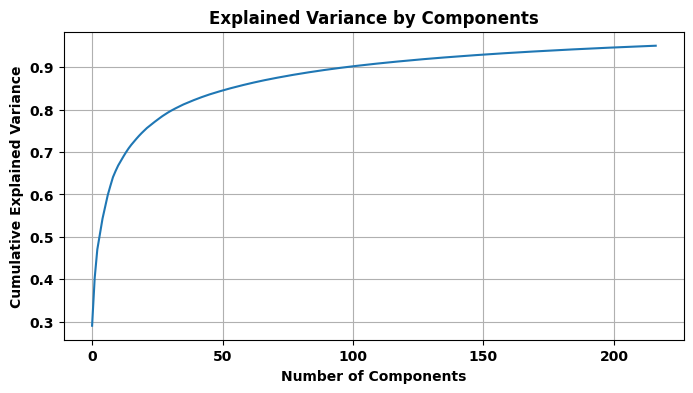

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()


### Modeling

Build an ML model for the original dataset.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split training dataset into training and validation set
X_train_orig, X_validate_orig, y_train_orig, y_validate_orig = train_test_split(
    train_images_flat, train_labels.flatten(), test_size=0.2, random_state=42
)

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_orig, y_train_orig)

DecisionTreeClassifier()

Ensemble method: Random Forest

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split training dataset into training and validation set
X_train_orig, X_validate_orig, y_train_orig, y_validate_orig = train_test_split(
    train_images_flat, train_labels.flatten(), test_size=0.2, random_state=42
)

forest_model = RandomForestClassifier(n_estimators=500, random_state=42)
forest_model.fit(X_train_orig, y_train_orig)

RandomForestClassifier(n_estimators=500, random_state=42)

Train on PCA-reduced data

In [19]:
X_train_pca, X_validate_pca, y_train_pca, y_validate_pca = train_test_split(
    train_images_pca, train_labels.flatten(), test_size=0.2, random_state=42
)

tree_model_PCA = DecisionTreeClassifier()
tree_model_PCA.fit(X_train_pca, y_train_pca)

forest_model_PCA = RandomForestClassifier(n_estimators=500, random_state=42)
forest_model_PCA.fit(X_train_pca, y_train_pca)

RandomForestClassifier(n_estimators=500, random_state=42)

SVM

In [22]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_classifier.fit(X_train_orig, y_train_orig)

svm_classifier_PCA = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_classifier_PCA.fit(X_train_pca, y_train_pca)

SVC()

Export models

In [26]:
import joblib

# Save the models to a file
joblib.dump(tree_model, 'models/dt_model.pkl')
joblib.dump(tree_model_PCA, 'models/dt_PCA_model.pkl')

joblib.dump(forest_model, 'models/forest_model.pkl')
joblib.dump(forest_model_PCA, 'models/forest_PCA_model.pkl')

joblib.dump(svm_classifier, 'models/svm_model.pkl')
joblib.dump(svm_classifier_PCA, 'models/svm_PCA_model.pkl')


['models/svm_PCA_model.pkl']

Compare performance

In [23]:
from sklearn.metrics import accuracy_score

# Decision Tree
# original model
accuracy_orig_dt = accuracy_score(y_validate_orig, tree_model.predict(X_validate_orig))
# PCA model
accuracy_pca_dt = accuracy_score(y_validate_pca, tree_model_PCA.predict(X_validate_pca))

# Random Forest
# original model
accuracy_orig_rf = accuracy_score(y_validate_orig, forest_model.predict(X_validate_orig))
# PCA model
accuracy_pca_rf = accuracy_score(y_validate_pca, forest_model_PCA.predict(X_validate_pca))

# SVM
# original model
accuracy_orig_svm = accuracy_score(y_validate_orig, svm_classifier.predict(X_validate_orig))
# PCA model
accuracy_pca_svm = accuracy_score(y_validate_pca, svm_classifier_PCA.predict(X_validate_pca))

print("Decision Tree")
print("Accuracy on original data:", accuracy_orig_dt)
print("Accuracy on PCA-reduced data:", accuracy_pca_dt)

print("Random Forest")
print("Accuracy on original data:", accuracy_orig_rf)
print("Accuracy on PCA-reduced data:", accuracy_pca_rf)

print("SVM")
print("Accuracy on original data:", accuracy_orig_svm)
print("Accuracy on PCA-reduced data:", accuracy_pca_svm)


Decision Tree
Accuracy on original data: 0.2577
Accuracy on PCA-reduced data: 0.2457
Random Forest
Accuracy on original data: 0.4804
Accuracy on PCA-reduced data: 0.4808
SVM
Accuracy on original data: 0.5321
Accuracy on PCA-reduced data: 0.5307


### Convolutional Neural Network (CNN)

In this example model a total of 9 layers such as Input, Conv2D, MaxPooling2D, Flatten, Dense . Every layer has its own hyper-parameters. Sequential operation

In [24]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255                                     
x_test = x_test.astype("float32") / 255

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape= (32,32,3)),                                          
        tf.keras.layers.Conv2D(32, 3, padding = "valid", activation = "relu"),             
        tf.keras.layers.MaxPooling2D(pool_size = (2,2)),                                  
        tf.keras.layers.Conv2D(64, 3, activation = "relu"),                                                            
        tf.keras.layers.MaxPooling2D(pool_size = (2,2)),                                  
        tf.keras.layers.Conv2D(128, 3, activation = "relu"),                             
        tf.keras.layers.Flatten(),                                                        
        tf.keras.layers.Dense(64, activation = "relu"),                                   
        tf.keras.layers.Dense(10, activation='softmax'),                                                        
    
    ]
)

model.summary()  

# from keras.utils import plot_model
# plot_model(model, to_file = 'model.png')


model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),     
    optimizer = keras.optimizers.Adam(learning_rate=3e-4),                               
    metrics =["accuracy"],                                                       
)

model_cnn = model.fit(x_train, y_train, batch_size = 64, epochs = 10,verbose = 2) 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
782/782 - 14s - 18ms/step - accuracy: 0.3959 - loss: 1.6531
Epoch 2/10
782/782 - 14s - 18ms/step - accuracy: 0.5181 - loss: 1.3463
Epoch 3/10
782/782 - 13s - 16ms/step - accuracy: 0.5657 - loss: 1.2266
Epoch 4/10
782/782 - 13s - 16ms/step - accuracy: 0.6068 - loss: 1.1291
Epoch 5/10
782/782 - 14s - 17ms/step - accuracy: 0.6322 - loss: 1.0616
Epoch 6/10
782/782 - 12s - 15ms/step - accuracy: 0.6565 - loss: 0.9923
Epoch 7/10
782/782 - 12s - 16ms/step - accuracy: 0.6765 - loss: 0.9388
Epoch 8/10
782/782 - 13s - 16ms/step - accuracy: 0.6927 - loss: 0.8935
Epoch 9/10
782/782 - 13s - 17ms/step - accuracy: 0.7058 - loss: 0.8567
Epoch 10/10
782/782 - 20s - 26ms/step - accuracy: 0.7181 - loss: 0.8196


<function matplotlib.pyplot.show(close=None, block=None)>

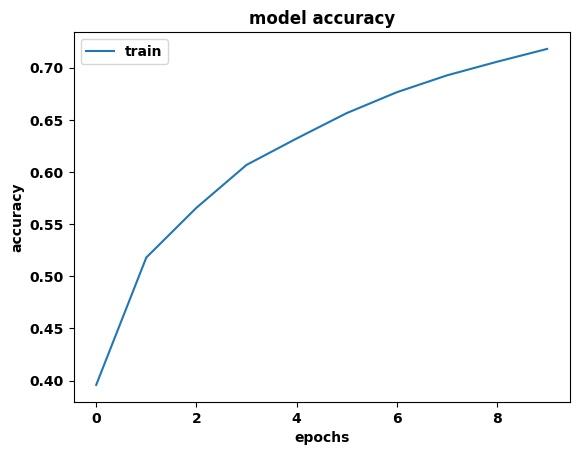

In [26]:
plt.plot(model_cnn.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train'], loc = 'upper left')
plt.show

PCA

In [27]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model architecture
model = Sequential([
    tf.keras.layers.Input(shape=(100,)),  # Input layer matching the PCA components
    Dense(512, activation='relu'),        # First dense layer
    Dropout(0.5),                         # Dropout for regularization
    Dense(256, activation='relu'),        # Second dense layer
    Dropout(0.5),
    Dense(128, activation='relu'),        # Third dense layer
    Dropout(0.3),
    Dense(10, activation='softmax')       # Output layer for 10 classes
])

# Print model summary to check the architecture
# model.summary()



model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),     
    optimizer = keras.optimizers.Adam(learning_rate=3e-4),                               
    metrics =["accuracy"],                                                       
)

model_cnn = model.fit(train_images_pca, train_labels, batch_size = 64, epochs = 10,verbose = 2) 


Epoch 1/10
782/782 - 4s - 5ms/step - accuracy: 0.2372 - loss: 2.0846
Epoch 2/10
782/782 - 3s - 3ms/step - accuracy: 0.3361 - loss: 1.8410
Epoch 3/10
782/782 - 3s - 3ms/step - accuracy: 0.3745 - loss: 1.7510
Epoch 4/10
782/782 - 3s - 3ms/step - accuracy: 0.4000 - loss: 1.6939
Epoch 5/10
782/782 - 3s - 3ms/step - accuracy: 0.4149 - loss: 1.6444
Epoch 6/10
782/782 - 3s - 3ms/step - accuracy: 0.4296 - loss: 1.6087
Epoch 7/10
782/782 - 3s - 3ms/step - accuracy: 0.4433 - loss: 1.5637
Epoch 8/10
782/782 - 2s - 3ms/step - accuracy: 0.4575 - loss: 1.5316
Epoch 9/10
782/782 - 3s - 3ms/step - accuracy: 0.4663 - loss: 1.5025
Epoch 10/10
782/782 - 3s - 3ms/step - accuracy: 0.4759 - loss: 1.4782
